### **Inisialisasi Library**

In [54]:
import pandas as pd
import re
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
import ast
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from nltk import trigrams
from nltk import bigrams
from collections import Counter

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Kinan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### **Inisialisasi Dataset**

In [55]:
# Load Dataset Kilang Minyak 
df = pd.read_csv('../tweets-data/kilang_minyak_data.csv')
# Load Dataset chatwords (informal → formal)
df_stopwords = pd.read_csv('../dataset/data_text_informal_to_formal.csv', sep=';')\

df.head()

,conversation_id_str,created_at,favorite_count,full_text,id_str,image_url,in_reply_to_screen_name,lang,location,quote_count,reply_count,retweet_count,tweet_url,user_id_str,username
0,1972951637129134346,Tue Sep 30 23:29:37 +0000 2025,0,@luckylucky0971 @PaltiHutabarat Indonesia Emas...,1973168385430265873,NaN,luckylucky0971,in,NaN,0,0,0,https://x.com/undefined/status/197316838543026...,1717391087479009280,NaN
1,1972947312923283930,Tue Sep 30 23:27:00 +0000 2025,1,@MMicen @BosPurwa Dengarkan baik2 kata2 yang d...,1973167727994081465,NaN,MMicen,in,NaN,0,2,0,https://x.com/undefined/status/197316772799408...,1401854513045151745,NaN
2,1972978284955898175,Tue Sep 30 23:19:18 +0000 2025,0,@dhaintly Kalau bikin kilang otomatis gk ada p...,1973165789898518798,NaN,dhaintly,in,NaN,0,0,0,https://x.com/undefined/status/197316578989851...,1783681863229579264,NaN
3,1973162466503959040,Tue Sep 30 23:06:06 +0000 2025,23,Impor BBM Bebani APBN Purbaya Sebut Pertamina ...,1973162466503959040,NaN,NaN,in,NaN,1,11,9,https://x.com/undefined/status/197316246650395...,41730943,NaN
4,1972996978041872838,Tue Sep 30 22:54:42 +0000 2025,0,@Dennysiregar7 @pertamina @NasbiHasan Jadi kap...,1973159600397623474,NaN,Dennysiregar7,in,NaN,0,0,0,https://x.com/undefined/status/197315960039762...,181123786,NaN


### **Check dan Hapus Duplikasi**

In [56]:
df['full_text'].duplicated().sum()
print(f"Total data saat ini : {len(df['full_text'])}")

Total data saat ini : 2514


In [57]:
df['full_text'].value_counts()[df['full_text'].value_counts() > 1]

full_text
@ferrykoto Bantu menambahkan dari yg saya baca : 1. Kilang modular adalah kilang kapasitas kecil yg relatif lebih mudah pembuatannya daripada yg konvensional 2. Setiap kilang hanya bisa digunakan utk mengolah jenis minyak mentah/ BBM yg sesuai 3. Analisa saya pembuatan kilang modular    2
Kilang minyak                                                                                                                                                                                                                                                                                   2
K O C A K A T A U B O D O H ️ Lebih dari 50% Indonesia impor BBM dari Singapura yang notabene bukan negara penghasil minyak. Negara kecil kecil ini punya kilang minyak yang mampu memenuhi kebutuhan &gt;50% BBM Indonesia.                                                                    2
@randomable_ @grok ini temuan baru apa sudah lama dugaan korupsi 285 triliun Kilang minyak Balikpapan?                  

In [58]:
df = df.drop_duplicates(subset=['full_text'])
df['full_text'].duplicated().sum()

#save hasil data tanpa duplikasi
path_dataset = r"D:\Kuliah\Tugas\Semester 7\Pemrosesan Teks\crowl_data_tweet\CPMK-2\dataset_preprocessing\data_tanpa_duplikasi.csv"
df['full_text'].to_csv(path_dataset, index=False)
print("\n Duplikat berhasil dihapus dan disimpan ke 'data_tanpa_duplikasi.csv'")
print(f"Total data saat ini : {len(df['full_text'])}")



 Duplikat berhasil dihapus dan disimpan ke 'data_tanpa_duplikasi.csv'
Total data saat ini : 2508


### **Case Folding dan Text Cleaning**

In [59]:
def clean_text(text):
    if not isinstance(text, str):
        text = str(text)
    text = text.lower()                             # ubah ke huruf kecil
    text = re.sub(r'http\S+|www\.\S+', '', text)    # hapus URL
    text = re.sub(r'@\w+', '', text)                # hapus mention (@username)
    text = re.sub(r'#\w+', '', text)                # hapus hashtag (#hashtag)
    text = re.sub(r'[^a-z\s]', '', text)            # hapus karakter non-huruf
    text = re.sub(r'\s+', ' ', text).strip()        # hapus spasi berlebih
    return text

df['cleaned_text'] = df['full_text'].apply(clean_text)

#save hasil data yang sudah bersih 
path_dataset = r"D:\Kuliah\Tugas\Semester 7\Pemrosesan Teks\crowl_data_tweet\CPMK-2\dataset_preprocessing\data_cleaned.csv"
df['cleaned_text'].to_csv(path_dataset, index=False)
print("Data berhasil dibersihkan dan disimpan ke 'data_cleaned.csv'")


Data berhasil dibersihkan dan disimpan ke 'data_cleaned.csv'


### **Handling Chatwords dan Stopword**

In [60]:

formal_text = df_stopwords.set_index('transformed')['original-for'].to_dict()

# Fungsi untuk mengganti kata chatwords
def replace_chatwords(text):
    words = text.split()
    replaced_words = [formal_text.get(word, word) for word in words]
    return ' '.join(replaced_words)

df['cleaned_text'] = df['cleaned_text'].apply(replace_chatwords)

# Stopword removal menggunakan Sastrawi

factory = StopWordRemoverFactory()
stopword = factory.create_stop_word_remover()
df['cleaned_text'] = df['cleaned_text'].apply(stopword.remove)



#save hasil data yang talah dilakukan handling Stopwords dan chatwords
path_dataset = r"D:\Kuliah\Tugas\Semester 7\Pemrosesan Teks\crowl_data_tweet\CPMK-2\dataset_preprocessing\data_cleaned_stopword_chatwords.csv"
df['cleaned_text'].to_csv(path_dataset, index=False)
print("Data berhasil disimpan ke 'data_cleaned_stopword_chatwords.csv'")

Data berhasil disimpan ke 'data_cleaned_stopword_chatwords.csv'


In [61]:
# Cek hasil perbandingan kata
df[['full_text', 'cleaned_text']].head()

,full_text,cleaned_text
0,@luckylucky0971 @PaltiHutabarat Indonesia Emas...,indonesia emas pak presiden bangun industri ot...
1,@MMicen @BosPurwa Dengarkan baik2 kata2 yang d...,dengarkan baik kata ucapkan udah jelas fokus d...
2,@dhaintly Kalau bikin kilang otomatis gk ada p...,kalau bikin kilang otomatis ada proyek import ...
3,Impor BBM Bebani APBN Purbaya Sebut Pertamina ...,impor bbm bebani apbn purbaya sebut pertamina ...
4,@Dennysiregar7 @pertamina @NasbiHasan Jadi kap...,jadi kapan pertamina mulai membangun kilang co...


### **Tokenizer**

In [62]:
df['tokenized_text'] = df['cleaned_text'].apply(word_tokenize)

#save hasil data hasil tokenizer
path_dataset = r"D:\Kuliah\Tugas\Semester 7\Pemrosesan Teks\crowl_data_tweet\CPMK-2\dataset_preprocessing\data_tokenizer.csv"
df['cleaned_text'].to_csv(path_dataset, index=False)
print("Data berhasil dilakukan tokenizer dan disimpan ke 'data_tokenizer.csv'")

Data berhasil dilakukan tokenizer dan disimpan ke 'data_tokenizer.csv'


In [63]:
df[['cleaned_text', 'tokenized_text']].head()

,cleaned_text,tokenized_text
0,indonesia emas pak presiden bangun industri ot...,"[indonesia, emas, pak, presiden, bangun, indus..."
1,dengarkan baik kata ucapkan udah jelas fokus d...,"[dengarkan, baik, kata, ucapkan, udah, jelas, ..."
2,kalau bikin kilang otomatis ada proyek import ...,"[kalau, bikin, kilang, otomatis, ada, proyek, ..."
3,impor bbm bebani apbn purbaya sebut pertamina ...,"[impor, bbm, bebani, apbn, purbaya, sebut, per..."
4,jadi kapan pertamina mulai membangun kilang co...,"[jadi, kapan, pertamina, mulai, membangun, kil..."


### **Stemming**

In [64]:
stem_factory = StemmerFactory()
stemmer = stem_factory.create_stemmer()

def stem_text(word_list):
    # Kalau input berupa string, ubah jadi list dulu
    if isinstance(word_list, str):
        try:
            word_list = ast.literal_eval(word_list)  # parse string list
        except:
            word_list = word_list.split()  # fallback split biasa
    if not isinstance(word_list, list):
        return []
    return [stemmer.stem(word) for word in word_list]

df['stemmed_text'] = df['tokenized_text'].apply(stem_text)

#save hasil data hasil Stemming
path_dataset = r"D:\Kuliah\Tugas\Semester 7\Pemrosesan Teks\crowl_data_tweet\CPMK-2\dataset_preprocessing\data_stemming.csv"
df['cleaned_text'].to_csv(path_dataset, index=False)
print("Data berhasil dilakukan Stemming dan disimpan ke 'data_Stemming.csv'")

Data berhasil dilakukan Stemming dan disimpan ke 'data_Stemming.csv'


In [65]:
df[['tokenized_text', 'stemmed_text']].head()

,tokenized_text,stemmed_text
0,"[indonesia, emas, pak, presiden, bangun, indus...","[indonesia, emas, pak, presiden, bangun, indus..."
1,"[dengarkan, baik, kata, ucapkan, udah, jelas, ...","[dengar, baik, kata, ucap, udah, jelas, fokus,..."
2,"[kalau, bikin, kilang, otomatis, ada, proyek, ...","[kalau, bikin, kilang, otomatis, ada, proyek, ..."
3,"[impor, bbm, bebani, apbn, purbaya, sebut, per...","[impor, bbm, beban, apbn, purbaya, sebut, pert..."
4,"[jadi, kapan, pertamina, mulai, membangun, kil...","[jadi, kapan, pertamina, mulai, bangun, kilang..."


### **(PERTEMUAN 4 - Normalisasi Kata, Bi-gram, Tri-gram, dan wordcloud)**

### **Normalisasi Kata**

In [66]:
### **Normalisasi Kata**

# Contoh kamus normalisasi (bisa diperluas)
normalisasi_kata = {
    "gak": "tidak",
    "nggak": "tidak",
    "ga": "tidak",
    "tdk": "tidak",
    "dr": "dari",
    "yg": "yang",
    "dgn": "dengan",
    "sdh": "sudah",
    "bgt": "banget",
    "bikin": "membuat",
    "aja": "saja"
}

def normalisasi_teks(text):
    words = text.split()
    normalized = [normalisasi_kata.get(word, word) for word in words]
    return ' '.join(normalized)

df['normalized_text'] = df['cleaned_text'].apply(normalisasi_teks)

# Simpan hasil normalisasi
path_dataset = r"D:\Kuliah\Tugas\Semester 7\Pemrosesan Teks\crowl_data_tweet\CPMK-2\dataset_preprocessing\data_normalisasi.csv"
df['normalized_text'].to_csv(path_dataset, index=False)

print("✅ Normalisasi kata selesai dan disimpan ke 'data_normalisasi.csv'")
df[['cleaned_text', 'normalized_text']].head()


✅ Normalisasi kata selesai dan disimpan ke 'data_normalisasi.csv'


,cleaned_text,normalized_text
0,indonesia emas pak presiden bangun industri ot...,indonesia emas pak presiden bangun industri ot...
1,dengarkan baik kata ucapkan udah jelas fokus d...,dengarkan baik kata ucapkan udah jelas fokus d...
2,kalau bikin kilang otomatis ada proyek import ...,kalau membuat kilang otomatis ada proyek impor...
3,impor bbm bebani apbn purbaya sebut pertamina ...,impor bbm bebani apbn purbaya sebut pertamina ...
4,jadi kapan pertamina mulai membangun kilang co...,jadi kapan pertamina mulai membangun kilang co...


### **Bigram**

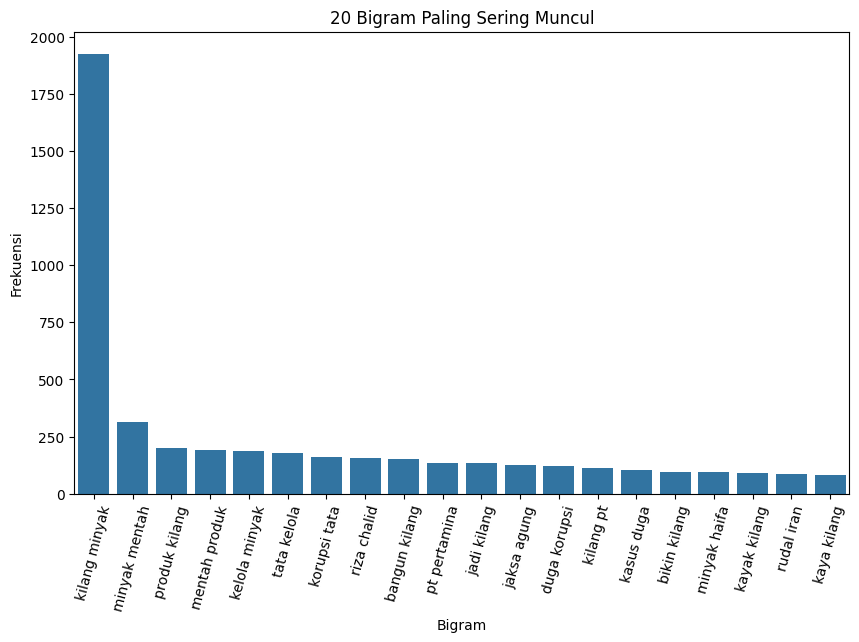

In [67]:
# Buat list bigram dari kolom stemmed_text
df['bigrams'] = df['stemmed_text'].apply(lambda x: list(bigrams(x)) if isinstance(x, list) else [])

# Hitung frekuensi bigram
all_bigrams = [bg for row in df['bigrams'] for bg in row]
bigram_counts = Counter(all_bigrams)

# Ambil 20 bigram paling sering
most_common_bigrams = bigram_counts.most_common(20)

# Visualisasi
plt.figure(figsize=(10,6))
sns.barplot(x=[f"{a} {b}" for (a,b), _ in most_common_bigrams],
            y=[count for _, count in most_common_bigrams])
plt.xticks(rotation=75)
plt.title("20 Bigram Paling Sering Muncul")
plt.xlabel("Bigram")
plt.ylabel("Frekuensi")
plt.show()


### **Trigram**

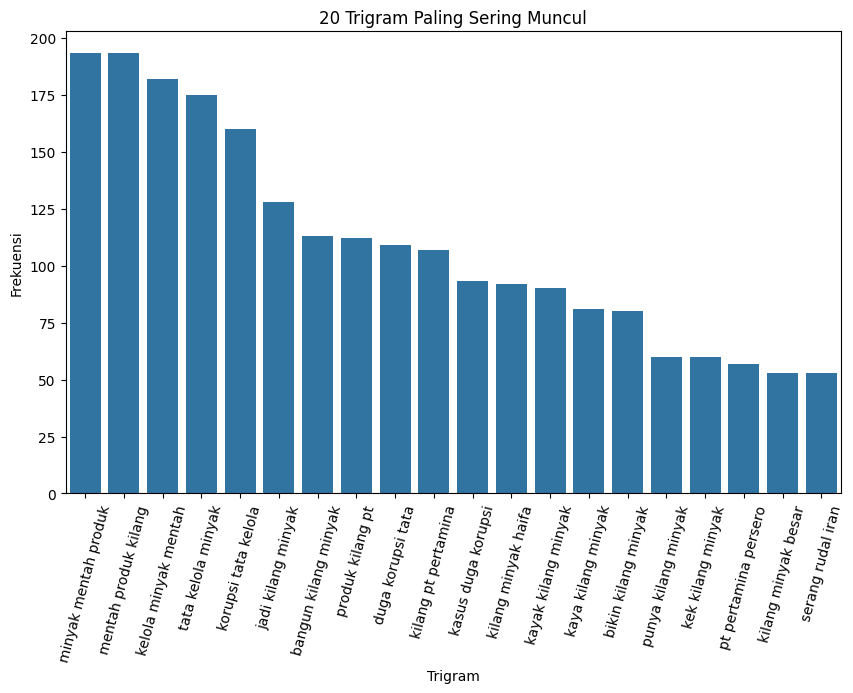

In [68]:
df['trigrams'] = df['stemmed_text'].apply(lambda x: list(trigrams(x)) if isinstance(x, list) else [])
all_trigrams = [tg for row in df['trigrams'] for tg in row]
trigram_counts = Counter(all_trigrams)

most_common_trigrams = trigram_counts.most_common(20)

plt.figure(figsize=(10,6))
sns.barplot(x=[' '.join(tg) for tg, _ in most_common_trigrams],
            y=[count for _, count in most_common_trigrams])
plt.xticks(rotation=75)
plt.title("20 Trigram Paling Sering Muncul")
plt.xlabel("Trigram")
plt.ylabel("Frekuensi")
plt.show()

### **WordCloud**

In [69]:
!pip install wordcloud


[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


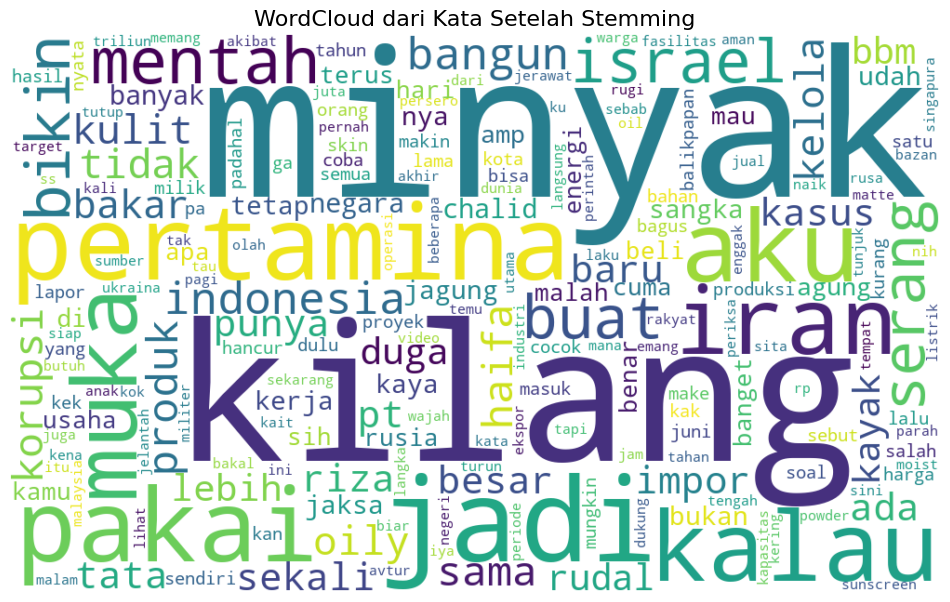

In [70]:
# Gabungkan semua kata hasil stemming
all_words = ' '.join([' '.join(words) for words in df['stemmed_text'] if isinstance(words, list)])

wordcloud = WordCloud(width=1000, height=600, background_color='white', collocations=False).generate(all_words)

plt.figure(figsize=(12,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud dari Kata Setelah Stemming", fontsize=16)
plt.show()
